# 从零开始实现神经网络框架

In [1]:
import numpy as np

In [3]:
from sklearn.datasets import load_boston

In [4]:
data = load_boston()

In [5]:
dataset = data['data']
labels = data['target']

### 计算节点

In [6]:
class Node:
    """
    计算图节点类基类
    """

    def __init__(self, inputs=None, name=''):
        if inputs is None:
            inputs = []
        self.inputs = inputs
        self.name = name
        self.value = None
        self.outputs = []
        self.gradients = {}  # 梯度
        self.graph = default_graph  # 计算图对象，默认为全局对象default_graph
        self.params = []

        for node in self.inputs:
            node.outputs.append(self)  # 建立节点之间的连接

        # 将本节点添加到计算图中
        self.graph.add_node(self)

    def forward(self):
        """
        前向传播计算本节点的值
        """
        raise NotImplemented

    def backward(self):
        """
        反向传播，计算结果节点对本节点的梯度
        """
        raise NotImplemented

    def clear_gradients(self):
        self.gradients.clear()

    def reset_value(self, recursive=True):
        """
        重置本节点的值，并递归重置本节点的下游节点的值
        """
        self.value = None
        if recursive:
            for o in self.outputs:
                o.reset_value()

    def __repr__(self):
        return '{}:{}'.format(self.__class__.__name__, self.name)

In [7]:
class PlaceHolder(Node):

    def __init__(self, shape=None, name='PlaceHolder'):
        super().__init__([], name)
        self.shape = shape

    def forward(self):
        pass

    def backward(self):
        pass

In [8]:
class Variable(Node):
    def __init__(self, value=None, name='Variable'):
        super().__init__([], name)
        self.value = value

    def forward(self):
        pass

    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost

In [9]:
class Linear(Node):
    def __init__(self, nodes, weights, bias, name='Linear'):
        super().__init__(inputs=[nodes, weights, bias], name=name)
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias

    def forward(self):
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value

    def backward(self):
        for node in self.outputs:
            # gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]

            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [10]:
class Sigmoid(Node):
    def __init__(self, node, name='Sigmoid'):
        super().__init__(inputs=[node], name=name)
        self.x_node = node
        self.partial = None

    def _sigmoid(self, x):
        return 1.0 / (1 + np.exp(-1 * x))

    def forward(self):
        self.value = self._sigmoid(self.x_node.value)

    def backward(self):
        y = self.value
        self.partial = y * (1 - y)
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial

In [11]:
class MSE(Node):
    """ 均方差loss """
    def __init__(self, y_true, y_hat, name='MSE'):
        super().__init__(inputs=[y_true, y_hat], name=name)
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        self.diff = None

    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean(self.diff ** 2)

    def backward(self):
        n = self.y_hat_node.value.shape[0]
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff

In [12]:
class Optimizer(Node):
    """
    优化器基类
    """

    def __init__(self, target, name='Optimizer'):
        super().__init__(inputs=[target], name=name)
        self.target = target

    def forward(self):
        # for node in self.graph.nodes:
        #     node.forward()
        self.backward()

    def backward(self):
        for node in self.graph.nodes[-2::-1]:
            node.backward()
        self.update()

    def update(self):
        """
        抽象方法，利用梯度更新可训练变量
        """
        raise NotImplemented

In [13]:
class GradientDescent(Optimizer):
    """
    梯度下降优化器
    """

    def __init__(self, target, batch_size, learning_rate=0.01, name='GradientDescent'):
        super().__init__(target, name=name)
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def update(self):
        for node in self.graph.params:
            gradient = node.gradients[node] / self.batch_size
            node.value += -1 * self.learning_rate * gradient

### 计算图框架

In [14]:
class Graph:
    """
    计算图类
    """

    def __init__(self):
        self.nodes = []  # 计算图内的节点的列表
        self.params = []  # 变量节点

    def add_node(self, node):
        """
        添加节点
        """
        self.nodes.append(node)
        if isinstance(node, Variable):
            self.params.append(node)

    def clear_gradients(self):
        """
        清除图中全部节点的雅可比矩阵
        """
        for node in self.nodes:
            node.clear_gradients()

    def reset_value(self):
        """
        重置图中全部节点的值
        """
        for node in self.nodes:
            node.reset_value(False)  # 每个节点不递归清除自己的子节点的值

    def as_default(self):
        global default_graph
        default_graph = self


# 全局默认计算图
default_graph = Graph()

In [15]:
from contextlib import contextmanager

class Session:

    def __init__(self, graph=default_graph):
        self.graph = graph
        # self.topological_sort()

    def topological_sort(self):
        G = {}
        nodes = [n for n in self.graph.nodes]
        while len(nodes) > 0:
            n = nodes.pop(0)
            if n not in G:
                G[n] = {'in': set(), 'out': set()}
            for m in n.outputs:
                if m not in G:
                    G[m] = {'in': set(), 'out': set()}
                G[n]['out'].add(m)
                G[m]['in'].add(n)
                nodes.append(m)

        L = []
        S = set(self.graph.nodes)
        while len(S) > 0:
            n = S.pop()
            L.append(n)
            for m in n.outputs:
                G[n]['out'].remove(m)
                G[m]['in'].remove(n)
                # if no other incoming edges add to S
                if len(G[m]['in']) == 0:
                    S.add(m)

        self.graph.nodes = L
        return L

    def eval(self, node):
        for n in node.inputs:
            self.eval(n)
        node.forward()
        return node.value

    def run(self, fetches, feed_dict=None):
        for k, v in feed_dict.items():
            if isinstance(k, PlaceHolder):
                k.value = v

        fetches_result = []
        for n in fetches:
            if n.value is None:
                fetches_result.append(self.eval(n))
            else:
                fetches_result.append(n.value)
        return tuple(fetches_result)

    @staticmethod
    @contextmanager
    def session(graph):
        sess = Session(graph)
        yield sess
        graph.reset_value()
        graph.clear_gradients()

In [16]:
def normal(shape, loc=0.0, scale=1.0):
    return np.random.normal(loc=loc, scale=scale, size=shape)

In [17]:
# 创建计算图
graph = Graph()
graph.as_default()

In [18]:
# 初始化参数
n_features = dataset.shape[1]  # X特征数
n_hidden = 100  # 隐藏层个数
X = PlaceHolder(name='X')
y = PlaceHolder(name='y')
W1 = Variable(normal((n_features, n_hidden), scale=1), name='W1')
b1 = Variable(np.zeros(n_hidden), name='b1')
W2 = Variable(normal((n_hidden, 1), scale=1), name='W2')
b2 = Variable(np.zeros(1), name='b2')

In [19]:
# 定义模型
linear_output = Linear(X, W1, b1, name='h1')
sigmoid_output = Sigmoid(linear_output, name='h1_sig')
yhat = Linear(sigmoid_output, W2, b2, name='yhat')
loss = MSE(y, yhat, name='loss')

In [20]:
epoch = 3001
batch_size = 64

In [21]:
# 创建优化器
optimizer = GradientDescent(loss, batch_size, learning_rate=0.001, name='sgd')

In [22]:
losses = []

训练

In [23]:
with Session.session(graph) as sess:
    for n in range(epoch):
        loss_sum = 0
        n_step = len(dataset) // batch_size + 1
        for i in range(n_step):
            b = i * batch_size
            e = b + batch_size
            if e > len(dataset):
                b = -batch_size
                e = len(dataset)
            batch_dataset = dataset[b:e]
            batch_labels = labels[b:e]
            _, los = sess.run([optimizer, loss], feed_dict={X: batch_dataset, y: batch_labels})
            loss_sum += los
        if n % 100 == 0:
            print('Epoch: {}, loss = {:.3f}'.format(n+1, loss_sum/n_step))
            losses.append(los)

Epoch: 1, loss = 541.138
Epoch: 101, loss = 86.765
Epoch: 201, loss = 72.227
Epoch: 301, loss = 70.571
Epoch: 401, loss = 69.982
Epoch: 501, loss = 69.649
Epoch: 601, loss = 69.272
Epoch: 701, loss = 68.700
Epoch: 801, loss = 68.400
Epoch: 901, loss = 68.234
Epoch: 1001, loss = 68.073
Epoch: 1101, loss = 67.929
Epoch: 1201, loss = 67.788
Epoch: 1301, loss = 67.650
Epoch: 1401, loss = 67.514
Epoch: 1501, loss = 67.187
Epoch: 1601, loss = 67.059
Epoch: 1701, loss = 66.934
Epoch: 1801, loss = 66.810
Epoch: 1901, loss = 66.683
Epoch: 2001, loss = 66.555
Epoch: 2101, loss = 66.436
Epoch: 2201, loss = 66.319
Epoch: 2301, loss = 66.163
Epoch: 2401, loss = 66.051
Epoch: 2501, loss = 65.940
Epoch: 2601, loss = 65.832
Epoch: 2701, loss = 65.726
Epoch: 2801, loss = 65.622
Epoch: 2901, loss = 65.520
Epoch: 3001, loss = 65.419


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

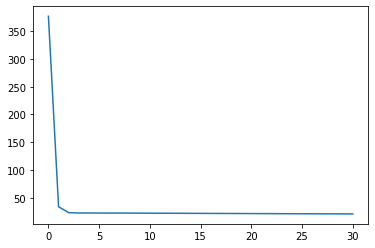

In [25]:
plt.plot(losses)
plt.show()

# 豆瓣评论分类

In [26]:
import pandas as pd

In [27]:
comment_file = r'D:\development\jupyter\datasource\movie_comments.csv'

In [28]:
comment = pd.read_csv(comment_file)

D:\development\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
comment.head()

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


In [30]:
comments = []
stars = []
for i in range(len(comment['star'])):
    try:
        stars.append(int(comment['star'][i]))
        comments.append(comment['comment'][i])
    except:
        pass


In [31]:
star = set()
for i in stars:
    star.add(i)
star

{1, 2, 3, 4, 5}

In [32]:
comment['star'][:10]

0    1
1    2
2    2
3    4
4    1
5    1
6    2
7    4
8    4
9    1
Name: star, dtype: object

In [33]:
import jieba
import re

In [34]:
def load_stop_words(path):
    stop_words = set()
    with open(path, encoding="utf-8") as f:
        for line in f:
            stop_words.add(line.strip())
    return stop_words

In [35]:
stop_words = load_stop_words(r'D:\development\jupyter\corpus\stop_words.txt')

In [36]:
def token(string):
    return ' '.join(re.findall(r'[\d|\w]+', string))

In [37]:
def cut(text):
    return [w for w in jieba.lcut(token(text)) if len(w.strip()) > 0 and w not in stop_words]

In [38]:
t = comment['comment'][1]
t

'首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮番上场，视物理逻辑于不顾，不得不说有钱真好，随意胡闹'

In [39]:
s = cut(token(t))
s

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\noone\AppData\Local\Temp\jieba.cache
Loading model cost 0.608 seconds.
Prefix dict has been built succesfully.


['首映礼',
 '太',
 '恐怖',
 '电影',
 '不讲道理',
 '吴京',
 '粉红',
 '英雄',
 '梦',
 '装备',
 '轮番',
 '上场',
 '视',
 '物理',
 '逻辑',
 '不顾',
 '说',
 '有钱',
 '真',
 '随意',
 '胡闹']

In [40]:
from gensim.models import Word2Vec

In [42]:
word2vec = Word2Vec.load(r'D:\development\jupyter\corpus\zhwiki_sougou_news_word2vec.model')

In [131]:
def sentence2vec(sentence):
    return np.mean([word2vec.wv[w] for w in cut(sentence) if w in word2vec.wv], axis=0)

In [126]:
np.mean([[1,2,3],[4,5,6]], axis=0)

array([2.5, 3.5, 4.5])

In [129]:
sentence2vec(t)

array([-0.4314901 , -0.21323907,  1.8681071 ,  0.08058092,  0.5520421 ,
        0.94416606,  0.16812155, -0.5000285 , -0.8309715 , -0.9423348 ,
        0.12564968, -0.662259  ,  0.681413  , -0.4508646 ,  0.6692805 ,
       -0.9565575 , -0.3335797 , -1.327392  ,  0.9559461 , -0.9573267 ,
        1.3100893 ,  0.4411884 ,  0.11875989,  0.02037793,  0.6158737 ,
       -0.73443556, -0.8963304 ,  1.462498  ,  0.01595178,  0.45038795,
        1.0694367 , -0.6588845 , -0.56813586, -0.40205342,  0.27342457,
       -0.36333033, -0.3247346 ,  0.7777479 ,  0.10208637,  0.83331925,
        0.16834512, -0.18541825, -0.530091  ,  0.14174439, -0.441872  ,
        0.41390347,  0.21868041,  0.8984635 ,  0.50942695, -0.42627645,
       -1.1100296 , -0.11748734, -1.0356447 , -1.22351   , -0.00699306,
        1.7741734 , -0.64081633,  0.40560696,  1.4500227 , -0.01240737,
        1.2645762 , -0.06243144, -0.360958  , -0.37007433,  0.3438284 ,
        0.13069817, -0.26574332, -0.17688648, -0.22753856, -1.26

In [136]:
dataset2 = [sentence2vec(i) for i in comments[:10000]]

In [139]:
np.isnan(dataset2).sum()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## 定义句子向量模型

使用普林斯顿的句子向量论文A SIMPLE BUT TOUGH-TO-BEAT BASELINE FOR SENTENCE EMBEDDINGS

In [44]:
import numpy as np
from sklearn.decomposition import TruncatedSVD


def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in sentence i
    :param w: w[i, :] are the weights for the words in sentence i
    :return: emb[i, :] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in range(n_samples):
        emb[i, :] = w[i, :].dot(We[x[i, :], :]) / np.count_nonzero(w[i, :])
    return emb


def compute_pc(X, npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_


def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc == 1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX


def SIF_embedding(We, x, w, params):
    """
    Compute the scores between pairs of sentences using weighted average + removing the projection on the first principal component
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in the i-th sentence
    :param w: w[i, :] are the weights for the words in the i-th sentence
    :param params.rmpc: if >0, remove the projections of the sentence embeddings to their first principal component
    :return: emb, emb[i, :] is the embedding for sentence i
    """
    emb = get_weighted_average(We, x, w)
    if params.rmpc > 0:
        emb = remove_pc(emb, params.rmpc)
    return emb


def getWordWeight(word_frequency, a=1e-3):
    if a <= 0:  # when the parameter makes no sense, use unweighted
        a = 1.0
    word2weight = {}
    N = 0
    for w, f in word_frequency.items():
        word2weight[w] = f
        N += f
    for key, value in word2weight.items():
        word2weight[key] = a / (a + value / N)
    return word2weight


def sentences2idx(sentences, words):
    """
    Given a list of sentences, output array of word indices that can be fed into the algorithms.
    :param sentences: a list of sentences
    :param words: a dictionary, words['str'] is the indices of the word 'str'
    :return: x1, m1. x1[i, :] is the word indices in sentence i, m1[i,:] is the mask for sentence i (0 means no word at the location)
    """
    seq1 = []
    for s in sentences:
        seq1.append(getSeq(s, words))
    x1, m1 = prepare_data(seq1)
    return x1, m1


def prepare_data(list_of_seqs):
    lengths = [len(s) for s in list_of_seqs]
    n_samples = len(list_of_seqs)
    maxlen = np.max(lengths)
    x = np.zeros((n_samples, maxlen)).astype('int32')
    x_mask = np.zeros((n_samples, maxlen)).astype('float32')
    for idx, s in enumerate(list_of_seqs):
        x[idx, :lengths[idx]] = s
        x_mask[idx, :lengths[idx]] = 1.
    x_mask = np.asarray(x_mask, dtype='float32')
    return x, x_mask


def getSeq(s, words_map):
    idx = []
    for w in s:
        if w in words_map:
            idx.append(words_map[w])
        else:
            idx.append(len(words_map) - 1)
    return idx


def getWeight(words, word2weight):
    weight4ind = {}
    for word, ind in words.items():
        if word in word2weight:
            weight4ind[ind] = word2weight[word]
        else:
            weight4ind[ind] = 1.0
    return weight4ind


def seq2weight(seq, mask, weight4ind):
    weight = np.zeros(seq.shape).astype('float32')
    for i in range(seq.shape[0]):
        for j in range(seq.shape[1]):
            if mask[i, j] > 0 and seq[i, j] >= 0:
                weight[i, j] = weight4ind[seq[i, j]]
    weight = np.asarray(weight, dtype='float32')
    return weight


class params(object):

    def __init__(self):
        self.LW = 1e-5
        self.LC = 1e-5
        self.eta = 0.05

    def __str__(self):
        t = "LW", self.LW, ", LC", self.LC, ", eta", self.eta
        t = map(str, t)
        return ' '.join(t)


class SIFModel:
    def __init__(self, word2vec_model, weightpara=1e-3):
        """
        :param word2vec_model: word2vec模型
        :param stop_words: 停用词
        :param weightpara:
        """
        self.word2vec_model = word2vec_model
        words = word2vec_model.wv.index2word
        self.word_vectors = word2vec_model.wv.vectors
        word_frequency = {w: v.count for w, v in word2vec_model.wv.vocab.items()}
        self.word_index_map = {w: n for n, w in enumerate(words)}
        word2weight = getWordWeight(word_frequency, weightpara)
        self.weight4ind = getWeight(self.word_index_map, word2weight)

    def sentence2vec(self, sentences):
        """
        计算句子向量
        :param sentences:
        :return:
        """
        sens = [cut(s) for s in sentences]
        x, m = sentences2idx(sens, self.word_index_map)
        w = seq2weight(x, m, self.weight4ind)
        p = params()
        p.rmpc = 0 if len(sentences) <= 1 else 1
        return SIF_embedding(self.word_vectors, x, w, p)


In [45]:
# 创建模型
sif_model = SIFModel(word2vec)

In [46]:
s2v = sif_model.sentence2vec([t])
s2v.shape, s2v

((1, 100),
 array([[-0.37148577, -0.14582501,  1.61984146,  0.07227427,  0.52611715,
          0.79112673,  0.15752387, -0.40599465, -0.79713565, -0.8083415 ,
          0.08923913, -0.62931818,  0.60452098, -0.24124436,  0.66816014,
         -1.01637352, -0.36557609, -1.32418454,  0.83325166, -0.73187137,
          1.06585884,  0.40391096,  0.11407755,  0.08116055,  0.63171309,
         -0.565512  , -0.84652507,  1.29514861,  0.01530122,  0.47093913,
          0.95852309, -0.57534248, -0.4818776 , -0.30580068,  0.1150021 ,
         -0.34451789, -0.20868465,  0.63513392,  0.02345112,  0.86482495,
          0.09472033, -0.19055696, -0.47505215,  0.23752721, -0.37120318,
          0.41446254,  0.18967609,  0.68884474,  0.40239415, -0.30909076,
         -0.88811129, -0.13006161, -0.81700778, -1.11770785,  0.09335148,
          1.65184915, -0.47939846,  0.43245053,  1.2934233 , -0.025197  ,
          1.20240521, -0.05018903, -0.31783891, -0.3727361 ,  0.3252449 ,
          0.05112781, -0.25

In [47]:
s2v[0].shape

(100,)

In [48]:
dataset = np.array([sif_model.sentence2vec([i])[0] for i in comments[:10000]])

D:\development\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [49]:
dataset.shape

(10000, 100)

In [50]:
dataset[0:100, :].shape

(100, 100)

In [100]:
dataset[10]

array([ 0.08239317, -0.42906678,  0.79234445,  0.02816611,  0.62318861,
        1.21528304, -0.50583208, -0.05945163, -0.83206856,  0.2146053 ,
        1.5383215 ,  0.09208171,  1.47147059,  0.08726862,  0.38526055,
       -0.07311188, -1.01709723,  0.31261376,  1.20884979, -1.48534298,
        2.40975857,  0.74284488, -0.39396742,  0.07520241, -0.70188618,
       -0.54689884,  0.3483099 ,  0.65707636,  0.44856936, -0.05704463,
        1.43716204, -0.72094291, -0.81099075,  0.37981534, -0.18492876,
        0.12555869, -0.47824076,  0.37308496,  0.52149045, -0.38853732,
       -0.29278687,  0.29526719, -1.55026436, -0.8495968 ,  0.1184432 ,
        0.38903669,  0.51281732,  1.38472247,  0.40694526, -1.6350652 ,
       -0.0486272 , -0.08006042, -0.55214089, -0.58384514, -0.38205394,
        1.39344573, -0.23462686, -0.48398241,  1.03827929,  0.75543386,
        1.68546772,  0.59013867,  0.11416898,  0.09117563, -1.57665789,
       -1.05298233,  0.16447324, -1.41008735, -0.45793965, -1.05

In [52]:
labels = np.array(stars[:10000])

In [53]:
labels = (np.arange(5) == labels[:,None]).astype(np.float32)

In [54]:
labels.shape

(10000, 5)

In [55]:
labels[0:100].shape

(100, 5)

In [124]:
np.isnan(dataset).sum()

8900

In [140]:
import pandas as pd

In [141]:
df = pd.DataFrame(dataset)

In [147]:
np.isnan(df.fillna(0).values).sum()

0

In [148]:
dataset = df.fillna(0).values

In [56]:
import tensorflow as tf

In [57]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [152]:
n_feature = 100
num_labels = 5
num_nodes= 1024
batch_size = 100

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, n_feature))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([n_feature, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1) # add relu layer
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    softmax = tf.nn.softmax(logits_2)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits_2, labels = tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)


In [ ]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    for step in range(num_steps):
        offset = (step * batch_size) % (labels.shape[0] - batch_size)
        batch_data = dataset[offset:(offset + batch_size), :]
        batch_labels = labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print("Minibatch loss at step {}: loss={}, accuracy={}".format(step, l, accuracy(predictions, batch_labels)))
